# Time-Series Analysis of the Hire-Art Data Analyst Exercise

This notebook will walk you through a brief time-series analysis of the Hire-Art Data Analyst Exercise hosted on Google Sheets [here](https://docs.google.com/spreadsheets/d/16hLtx8bBDe2GS1MOa3v9hY6Yhm4C30koLoCpiIJ5WDg/edit?usp=sharing).  

We show that the data has clear seasonal and trend elements that allows us to extrapolate in the near term with very high confidence.

You can explore both historical and forecasted data in the accompanying Dash app [here](https://citrusvanilla-cms-dashboard.herokuapp.com/).

Dependencies:
- Pandas 0.22
- Matplotlib
- StatsModels

## 1. Initialize Python environment, prepare dataset, and explore.

What we want to do is visualize the series and look for any clear indications that the data is subject to and common TS-related trends.  From our chart, we see a clear seasonal element with data spikes in the Fall, as well as an overall decreasing trend across time.

/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


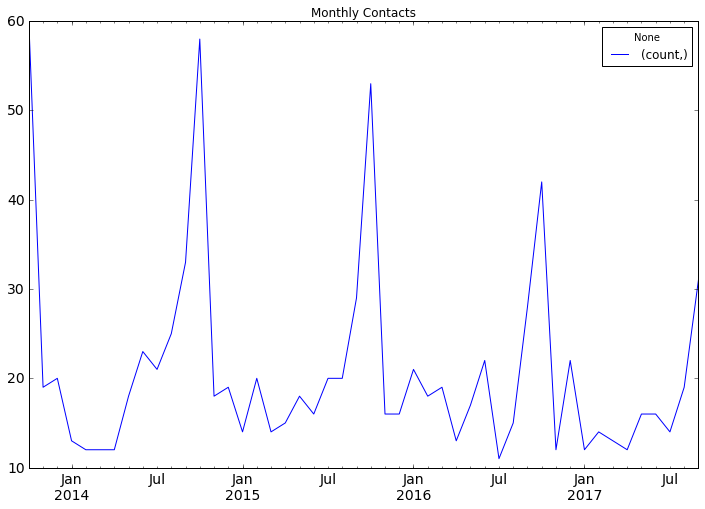

In [1]:
from __future__ import division

import os
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Import data from external CSV sheet.
data = pd.read_csv('data.csv')

# Format datetime and extract year and month separately.
data['Date of Contact'] = pd.to_datetime(data['Date of Contact'], format='%Y-%m-%d')
data['month'] = data['Date of Contact'].dt.month
data['year'] = data['Date of Contact'].dt.year

# Get a count of total contacts made, grouped by year and month.
df = data.groupby(['year','month'])['Client Name'].count().reset_index()

# Extract datetime elements and convert to pandas datetime type.
date_list = df['month'].astype(str) + "-" + df['year'].astype(str)
date_list = pd.to_datetime(date_list, format='%m-%Y')

# Integrate new datetime type into original dataframe and clean.
df['index'] = date_list
df = df.set_index(['index'])
df = df[['Client Name']]
df.columns = [['count']]
df.index.name = None

#Plot and show
df['count'].plot(figsize=(12,8), title= 'Monthly Contacts', fontsize=14)
plt.show()

## 2. Decompose the series.

Here we attempt to remove the TS-trends to arrive at a "stationary", time-dependent data process.  The 'seasonal_decompose' module from the StatsModels Time-Series library will plot and remove the common effects of trend and seasonality.  In our case, we see that after removal, the residual values are more-or-less stationary about a mean of 0, suggesting that both effects are likely present in the original series.

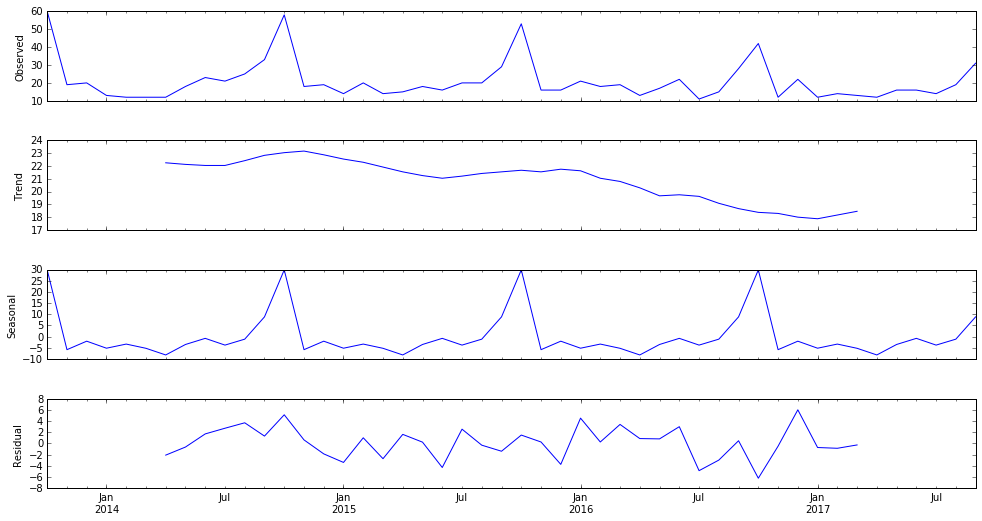

In [2]:
decomposition = seasonal_decompose(df['count'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

## 3. "Station-ize" the series.

We apply the "Dickey-Fuller" test, looking for significant p-statistic indicating the data set is indeed stationary after decomposition.  If stationary, we can use common statistical inference to make confident predictions from the series.  The resulting p-value after seasonal first-differencing is very significant, suggesting that after trend and seasonality, a stationary process underlies our dataset.

Due to the limited nature of our data in time (only 4 years), we cannot make use of the full power of a robust time-series forecasting model such as SARIMA, but due to the analysis presented here, we can be confident that other short term forecasting models that rely on regression, such as an exponential smoothing model with trend, will be accurate.

In [3]:
# test tationarity
def test_stationarity(timeseries):
    """
    This function plots a timeseries, applies the Dickey-Fuller
    test, and prints the results.
    
    Source:
      Sean Abu from seanabu.com.
    
    Args:
      timeseries: a 1D Pandas Dataframe with datetime index.
    
    Returns:
      VOID
    """
    # Determine rolling statistics.
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plot rolling statistics.
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print dfoutput

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


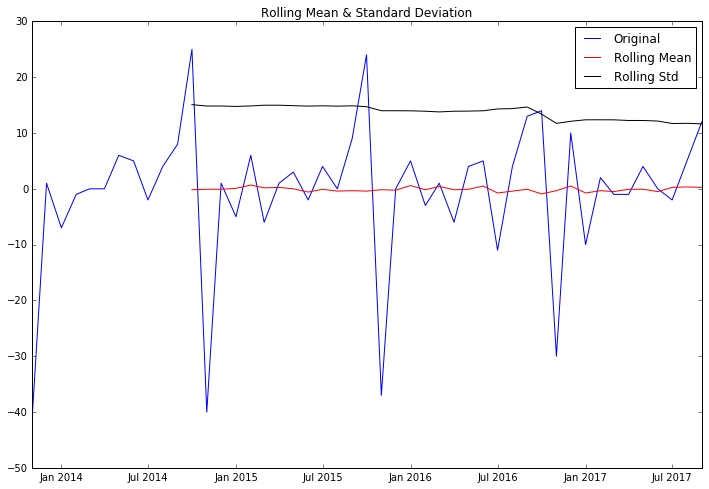

Results of Dickey-Fuller Test:
Test Statistic                -1.531271e+01
p-value                        4.165484e-28
#Lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (5%)           -2.945951e+00
Critical Value (1%)           -3.626652e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


In [4]:
# First Differencing
df['first_difference'] = df['count'] - df['count'].shift(1)
test_stationarity(df['first_difference'].dropna(inplace=False))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


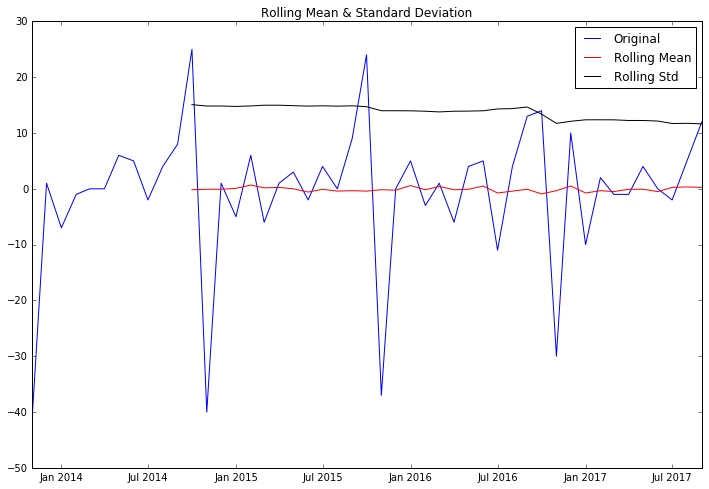

Results of Dickey-Fuller Test:
Test Statistic                -1.531271e+01
p-value                        4.165484e-28
#Lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (5%)           -2.945951e+00
Critical Value (1%)           -3.626652e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


In [5]:
# Seasonal
df['seasonal_difference'] = df['count'] - df['count'].shift(12)  
test_stationarity(df['first_difference'].dropna(inplace=False))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


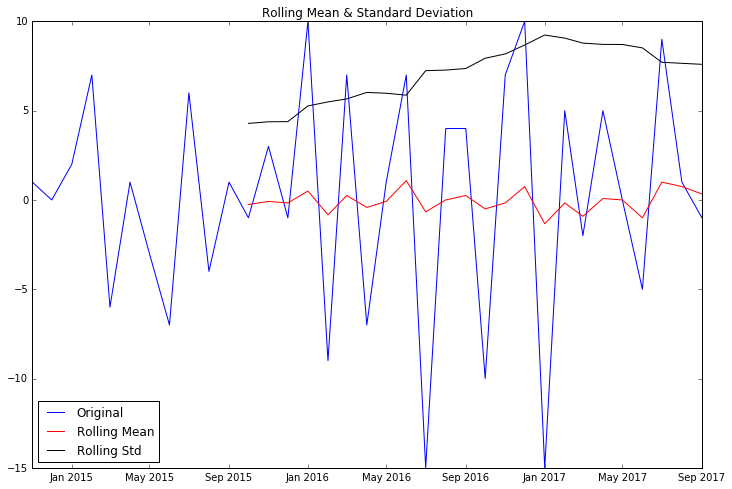

Results of Dickey-Fuller Test:
Test Statistic                -7.825974e+00
p-value                        6.480387e-12
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (5%)           -2.954127e+00
Critical Value (1%)           -3.646135e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


In [6]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
test_stationarity(df['seasonal_first_difference'].dropna(inplace=False))